In [28]:
#Importing the necessary Libraries
import pandas as pd
import numpy as np
import librosa
import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [16]:
#importing the files
train_df = pd.read_parquet("dataset/train-00000-of-00001.parquet")
test_df = pd.read_parquet("dataset/test-00000-of-00001.parquet")

print("Train Samples", len(train_df))
print("Test Samples",len(test_df))

Train Samples 2700
Test Samples 300


In [17]:
##Preprocessing starting here
def bytes_to_audio(audio_bytes,sr = 8000):
    audio,sr = librosa.load(io.BytesIO(audio_bytes),sr = sr)
    return audio,sr

def pad_audio(audio,target_length = 8000):
    if len(audio)<target_length:
        pad_width = target_length - len(audio)
        audio = np.pad(audio,(0,pad_width),mode = 'constant')
    else:
        audio = audio[:target_length]
    return audio


def extract_features(audio, sr=SAMPLE_RATE, n_mfcc=13):
    # MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs, axis=1)
    
    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Spectral features
    centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr))
    bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr))
    rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr))
    zcr = np.mean(librosa.feature.zero_crossing_rate(audio))
    
    feature_vector = np.concatenate([mfccs_mean, chroma_mean, [centroid, bandwidth, rolloff, zcr]])
    return feature_vector

def add_noise(audio, noise_factor=0.005):
    noise = np.random.randn(len(audio))
    audio_noisy = audio + noise_factor * noise
    audio_noisy = np.clip(audio_noisy, -1.0, 1.0)
    return audio_noisy

In [21]:
#Running all the preprocesing components

def preprocess_df(df, augment_noise = True):
    features = []
    labels = []
    
    for idx,row in df.iterrows():
        audio_bytes = row['audio']['bytes']
        label = row['label']
        audio,sr = bytes_to_audio(audio_bytes)
        audio = pad_audio(audio)
        
        features.append(extract_features(audio))
        labels.append(label)
        
        if augment_noise:
            audio_noise = add_noise(audio)
            features.append(extract_features(audio_noise))
            labels.append(label)
            
    return np.array(features),np.array(labels)

X_train, y_train = preprocess_df(train_df, augment_noise=True)
X_test, y_test = preprocess_df(test_df, augment_noise=False)

print("Train feature shape:", X_train.shape)
print("Test feature shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train feature shape: (5400, 29)
Test feature shape: (300, 29)


In [29]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_accuracies, svm_accuracies, lgb_accuracies = [], [], []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train)):
    X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]
    
    # Logistic Regression
    lr_model = LogisticRegression(max_iter=500)
    lr_model.fit(X_tr, y_tr)
    y_pred_lr = lr_model.predict(X_val)
    lr_accuracies.append(accuracy_score(y_val, y_pred_lr))
    
    # SVM
    svm_model = SVC(kernel='rbf', C=10)
    svm_model.fit(X_tr, y_tr)
    y_pred_svm = svm_model.predict(X_val)
    svm_accuracies.append(accuracy_score(y_val, y_pred_svm))
    
    # LightGBM
    lgb_tr = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_tr)
    params = {
        'objective': 'multiclass',
        'num_class': 10,
        'metric': 'multi_logloss',
        'learning_rate': 0.1,
        'num_leaves': 31
    }
    lgb_model = lgb.train(params, lgb_tr, num_boost_round=100, valid_sets=[lgb_val])
    y_pred_lgb = np.argmax(lgb_model.predict(X_val), axis=1)
    lgb_accuracies.append(accuracy_score(y_val, y_pred_lgb))

print("Logistic Regression CV Accuracy:", np.mean(lr_accuracies))
print("SVM CV Accuracy:", np.mean(svm_accuracies))
print("LightGBM CV Accuracy:", np.mean(lgb_accuracies))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 4320, number of used features: 29
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM]

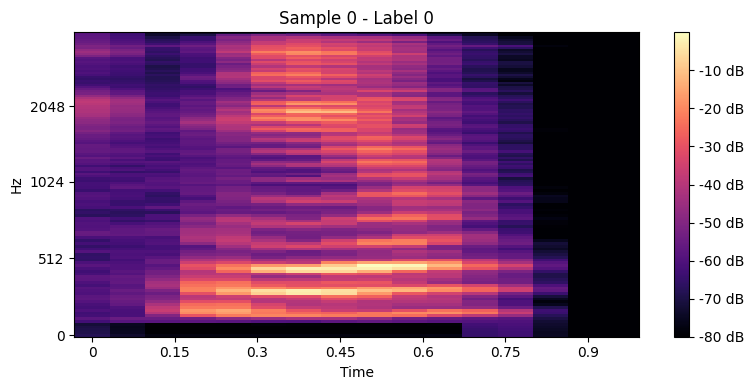

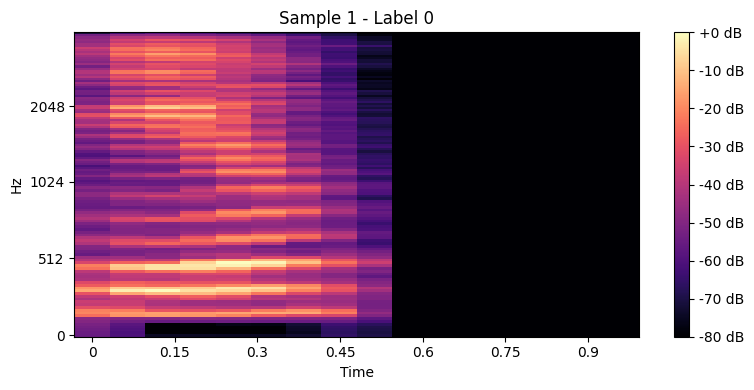

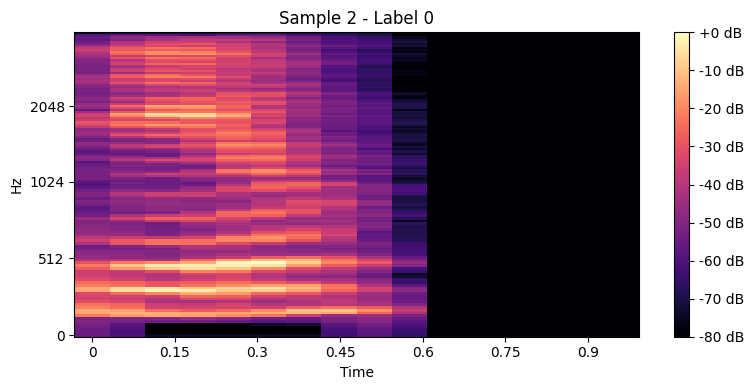

In [30]:
def plot_log_mel(audio, sr=SAMPLE_RATE, n_mels=128, fmax=4000, title="Log-Mel Spectrogram"):
    S = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=fmax)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(8,4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot first 3 samples
for i in range(3):
    audio_bytes = train_df['audio'][i]['bytes']
    label = train_df['label'][i]
    audio, sr = bytes_to_audio(audio_bytes)
    audio = pad_audio(audio)
    plot_log_mel(audio, title=f"Sample {i} - Label {label}")
